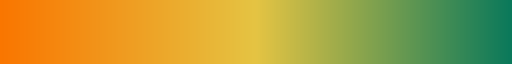

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patheffects
import matplotlib as mpl
import shap
import numpy as np

shap_red_rgb = shap.plots.colors.red_rgb.copy()
shap_blue_rgb = shap.plots.colors.blue_rgb.copy()
shap.plots.colors.red_rgb = np.array([10,121,91])/255
shap.plots.colors.blue_rgb = np.array([250,118,0])/255

newcmp = mpl.colors.LinearSegmentedColormap.from_list("newcmp", ["#fa7600", "#e5c443", "#0a795b"])
newcmp

In [2]:
def plot_shap(MODEL, TARGET, CONFIG):

    df = pd.read_pickle(f"../results/metrics--{TARGET}--{CONFIG}--{MODEL}.pickle")
    best_idx = df[df.NRMSE == df.NRMSE.min()].index[0]
    # print(best_idx)
    # display(df)
    df = pd.read_pickle(f"../results/predictions--{TARGET}--{CONFIG}--{MODEL}.pickle")
    row = df.loc[best_idx]
    # display(row)

    regressor = row.model_obj
    X_test = row.X_test
    X_train = row.X_train


    feature_mapping = {
        x: x.replace("pr_avg_JJA_median",  "PREC summer avg")\
            .replace("pr_avg_MAM_median",  "PREC spring avg")\
            .replace("tas_avg_JJA_median", "TEMP summer avg")\
            .replace("tas_max_JJA_median", "TEMP summer max")\
            .replace("tas_min_JJA_median", "TEMP summer min")\
            .replace("tas_avg_MAM_median", "TEMP spring avg")\
            .replace("tas_max_MAM_median", "TEMP spring max")\
            .replace("tas_min_MAM_median", "TEMP spring min")\
            .replace("_max", " max")\
            .replace("_min", " min")\
            .replace("_median", " med")\
            .replace("_mean", " avg")\
            .replace("_stdDev", " std")\
            .replace("_stdev", " std")\
            .replace("elevation", "ELE")\
            .replace("slope_percentage", "SLO")\
            .replace("aspect_degree", "ASP")\
            .replace("chm", "CHM")\
        for x in X_test.columns.tolist()
    }

    max_display=15
    explainer = shap.Explainer(regressor, X_test)
    shap_values = explainer(X_test)
    shap_values.feature_names = [feature_mapping[x] for x in shap_values.feature_names]
    feature_names = [feature_mapping[x] for x in X_test.columns]
    
    return explainer, shap_values, feature_names, max_display, row
    # plt.show()


In [3]:
def force_plot(explainer, shap_values, row, idx, feature_names):

    force = shap.force_plot(
        explainer.expected_value,
        shap_values.values[idx, :],
        row.X_test.iloc[idx, :],
        show=False,
        matplotlib=True,
        feature_names=feature_names,
        plot_cmap=["#fa7600", "#0a795b"],
        text_rotation=90,
        out_names = "predicted",
        contribution_threshold=0.02,
    )
    axes = plt.gcf().axes
    ax = axes[0]

    for x in ax.get_children():
        if type(x)==mpl.image.AxesImage:
            x.remove()
        elif type(x)==mpl.lines.Line2D:
            if x.get_color() == "#1E88E5":
                x.set(color="#fa7600")
            elif x.get_color() == "#FF0D57":
                x.set(color="#0a795b")
            else:
                x.remove()

    polys = [
        x for x in ax.get_children()
        if type(x)==mpl.patches.Polygon
        or type(x)==mpl.patches.PathPatch
    ]
    for poly in polys:

        if type(poly)==mpl.image.AxesImage:
            poly.remove()

        elif poly.get_facecolor() == (0.11764705882352941, 0.5333333333333333, 0.8980392156862745, 1.0):
            poly.set(fc="#fa7600")
        elif poly.get_facecolor() == (1.0, 0.050980392156862744, 0.3411764705882353, 1.0):
            poly.set(fc="#0a795b")
        elif poly.get_edgecolor() == (0.8196078431372549, 0.9019607843137255, 0.9803921568627451, 1.0):
            poly.set(ec="w", alpha=.7)
        elif poly.get_edgecolor() == (1.0, 0.7647058823529411, 0.8352941176470589, 1.0):
            poly.set(ec="w", alpha=.7)

    polys[-1].set(fc="#0a795b", alpha=.2)
    polys[-2].set(fc="#fa7600", alpha=.2)

    texts = [x for x in ax.get_children() if type(x)==mpl.text.Text]
    for text_obj in texts:
        text = text_obj.get_text()
        if "=" in text:

            if text_obj.get_color() == "#1E88E5":
                text_obj.set(color="#fa7600")
            elif text_obj.get_color() == "#FF0D57":
                text_obj.set(color="#0a795b")

            text_obj.set(
                text = text.split(" = ")[0].replace(" ", "\n") + "\n" + f'{float(text.split(" = ")[-1]):.2f}',
                ha = "center",
                va = "top",
                ma = "right",
                fontweight="bold"
            )

            text_obj.set(
                rotation = 0,
                va = "bottom",
                ma = "center",
                ha = "center",
                y = -0.19
            )



        else:
            try:
                f = float(text_obj.get_text())
            except:
                text_obj.set(text=None)
                continue

            text_obj.set(
                text = "predicted\n"+text_obj.get_text(),
                ha = "right",
            )

    ax.plot(
        [row.y_test[idx]]*2,
        [0.15, 0.25],
        marker="",
        color="k",
        lw=1,
    )
    ax.plot(
        [row.y_pred[idx]]*2,
        [0.15, 0.25],
        marker="",
        color="k",
        lw=1,
    )

    ax.plot(
        [row.y_pred[idx],row.y_test[idx]],
        [0.2,0.2],
        marker="^",
        ls="",
        ms=10,
        color="k",
    )
    ax.text(
        x=row.y_test[idx],
        y=0.25,
        s=f"real\n{row.y_test[idx]:.2f}",
        ha="left",
        va="baseline",
        fontweight="bold",
        fontsize="x-large",
    )
    plt.ylim(-.2, 0.22)

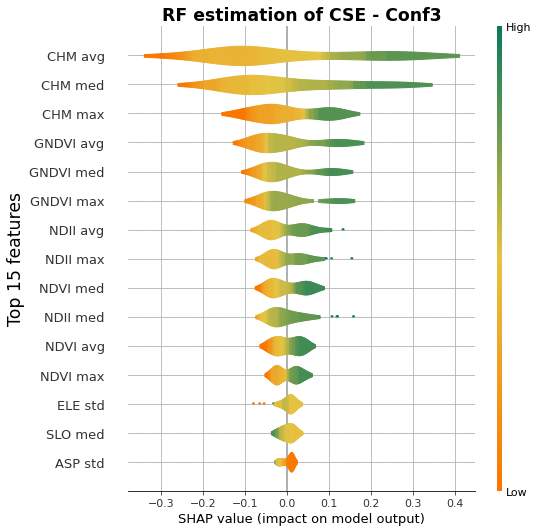

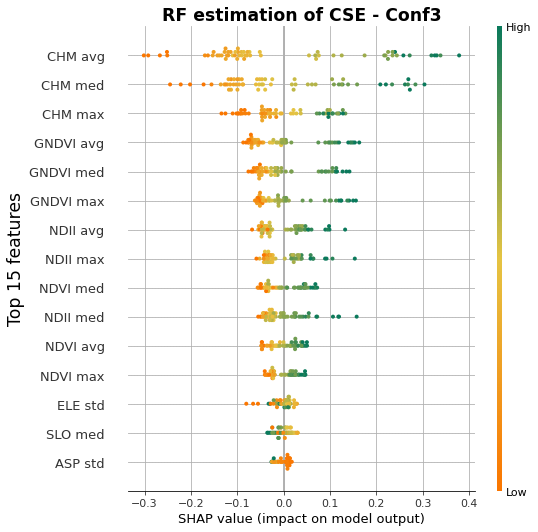

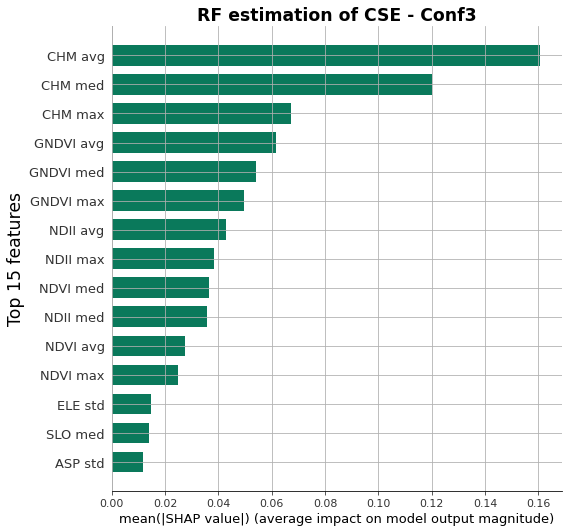

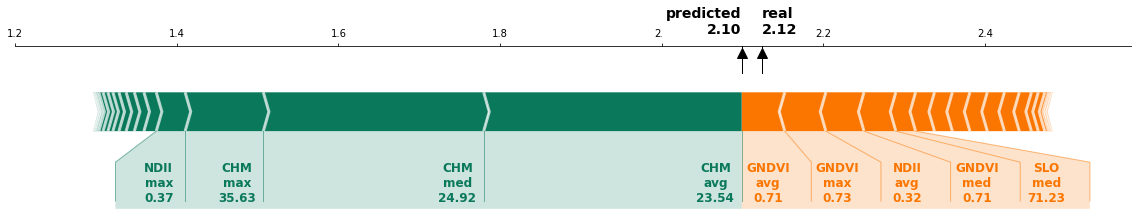

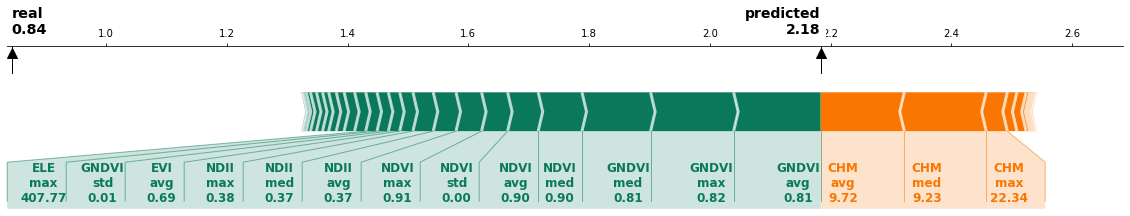

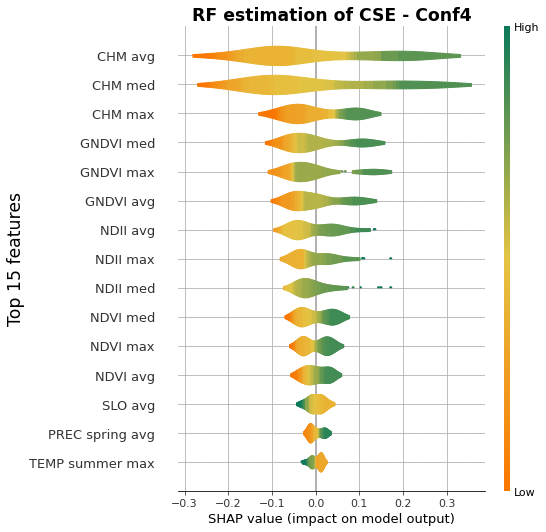

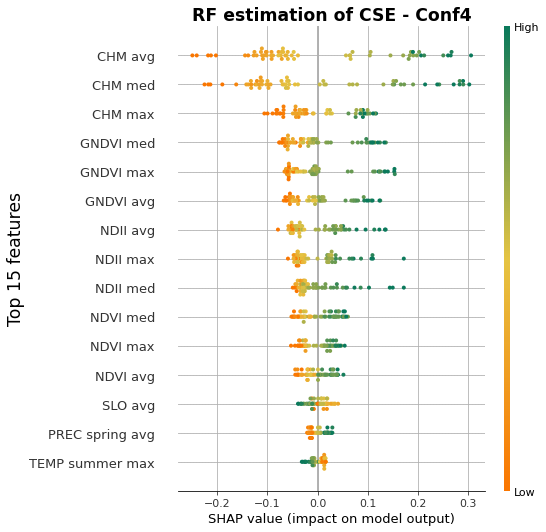

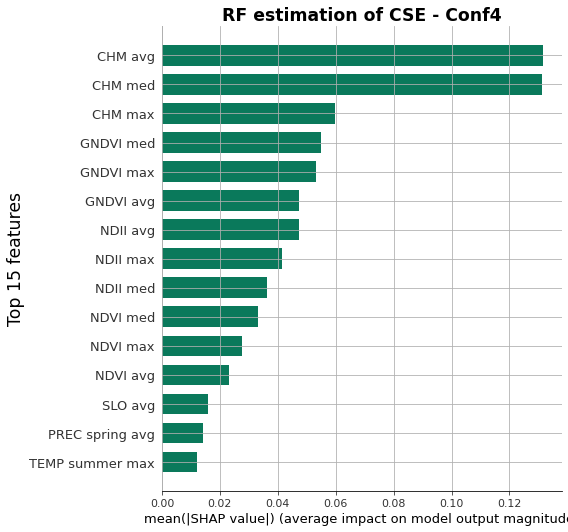

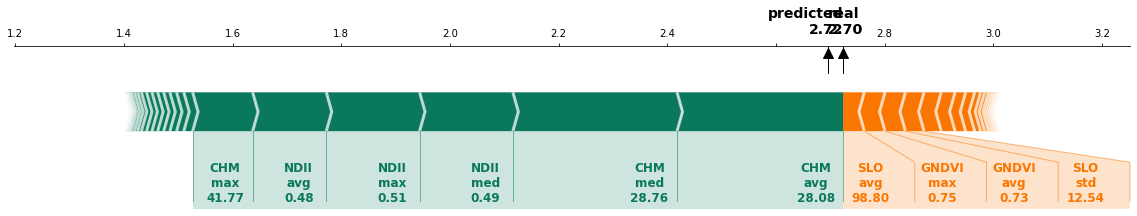

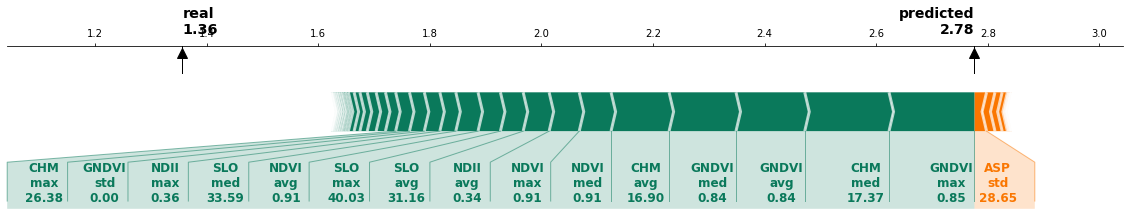

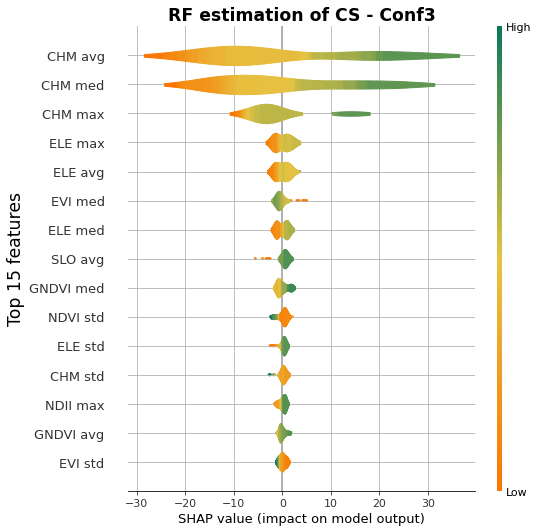

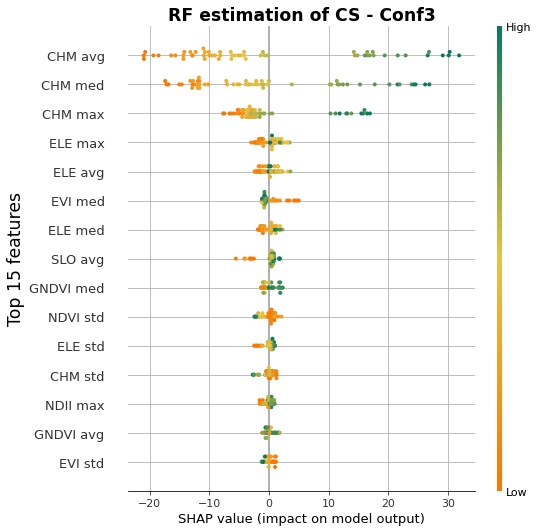

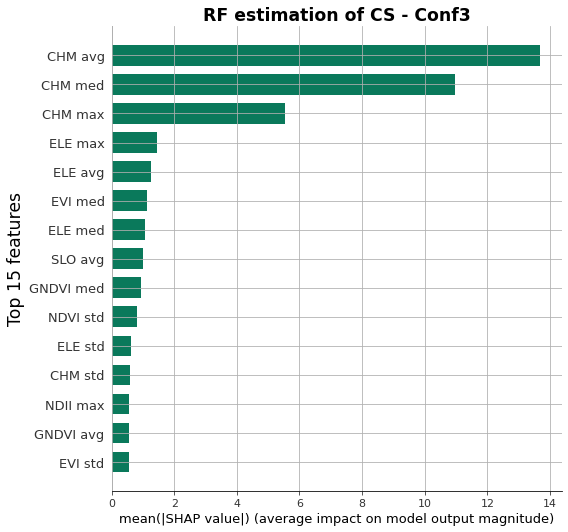

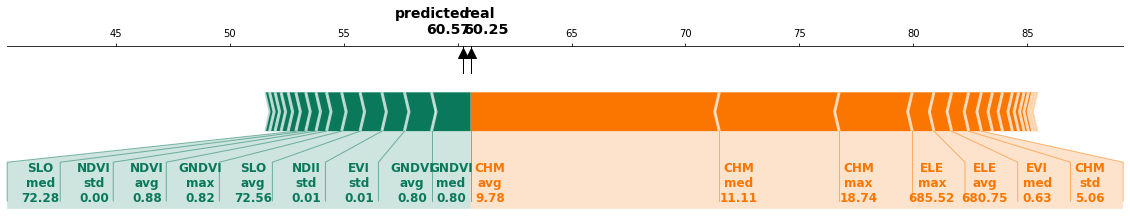

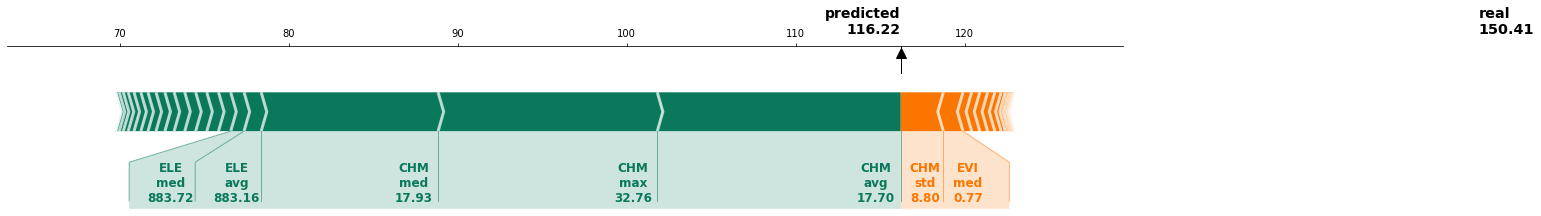

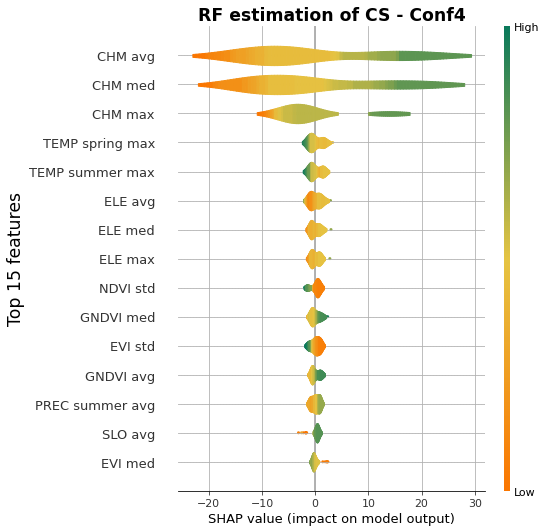

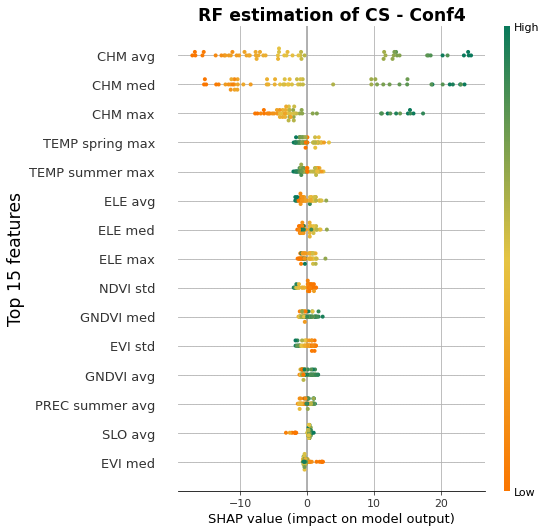

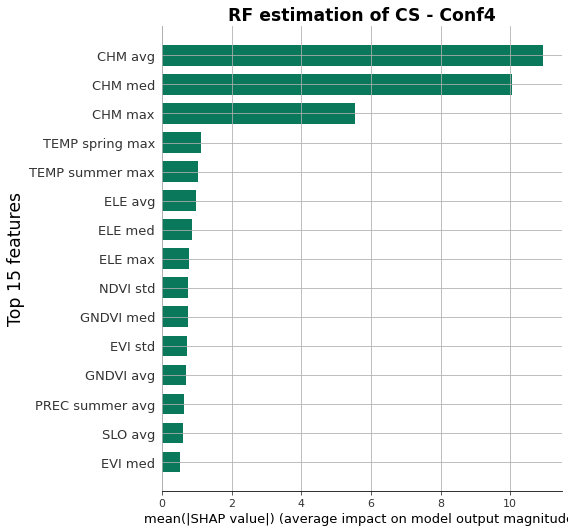

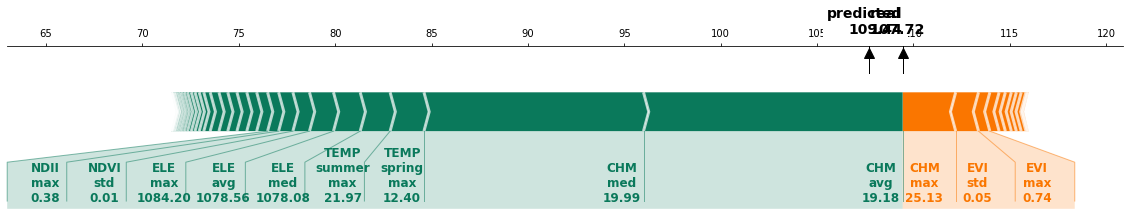

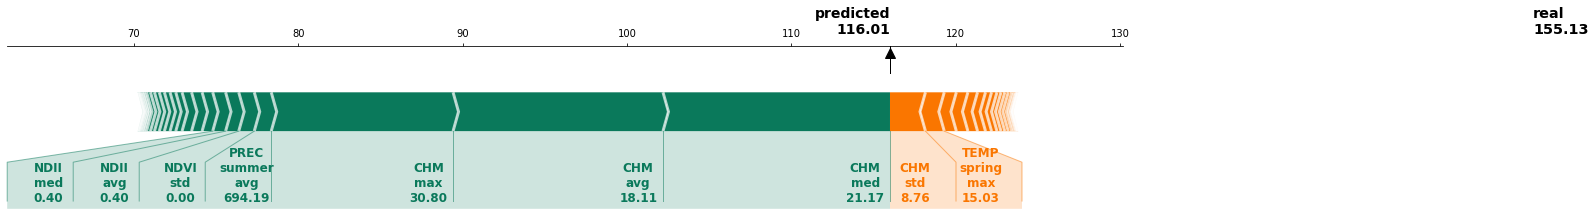

In [12]:
for MODEL in ["RF"]:
    for TARGET in ["CSE", "CS"]:
        for CONFIG in ["Conf3", "Conf4"]:
            explainer, shap_values, feature_names, max_display, row = plot_shap(MODEL, TARGET, CONFIG)
            
            # --------------------------------- violin plot
            shap.summary_plot(
                shap_values,
                feature_names=feature_names,
                show=False,
                plot_type="violin",
                cmap=newcmp,
                max_display=max_display,
                color_bar_label="",
            )
            plt.title(f"{MODEL} estimation of {TARGET} - {CONFIG}", fontsize="xx-large", fontweight="bold")
            plt.ylabel(f"Top {max_display} features", fontsize="xx-large")
            plt.grid()
            plt.tight_layout()
            plt.savefig(f"../figures_and_tables/figure_shap_VIOLIN_{MODEL}_{TARGET}_{CONFIG}.png", dpi=200)
            plt.show()
            
            # --------------------------------- summary plot
            shap.summary_plot(
                shap_values,
                feature_names=feature_names,
                show=False,
                cmap=newcmp,
                max_display=max_display,
                color_bar_label="",
            )
            plt.title(f"{MODEL} estimation of {TARGET} - {CONFIG}", fontsize="xx-large", fontweight="bold")
            plt.ylabel(f"Top {max_display} features", fontsize="xx-large")
            plt.grid()
            plt.tight_layout()
            plt.savefig(f"../figures_and_tables/figure_shap_SUMMARY_{MODEL}_{TARGET}_{CONFIG}.png", dpi=200)
            plt.show()
            
            # --------------------------------- bar plot
            
            shap.summary_plot(
                shap_values,
                feature_names=feature_names,
                show=False,
                plot_type="bar",
                cmap=newcmp,
                max_display=max_display,
                color_bar_label="",
                color="#0a795b",
            )
            plt.title(f"{MODEL} estimation of {TARGET} - {CONFIG}", fontsize="xx-large", fontweight="bold")
            plt.ylabel(f"Top {max_display} features", fontsize="xx-large")
            plt.grid()
            plt.tight_layout()
            plt.savefig(f"../figures_and_tables/figure_shap_BAR_{MODEL}_{TARGET}_{CONFIG}.png", dpi=200)
            plt.show()
            
            # --------------------------------- force plot (good pred)
            
            indices = abs(row.y_test - row.y_pred).argsort()

            force_plot(explainer, shap_values, row, indices[0], feature_names)
            plt.savefig(f"../figures_and_tables/figure_shap_FORCEgood_{MODEL}_{TARGET}_{CONFIG}.png", dpi=200)
            
            force_plot(explainer, shap_values, row, indices[-7], feature_names)
            plt.savefig(f"../figures_and_tables/figure_shap_FORCEbad_{MODEL}_{TARGET}_{CONFIG}.png", dpi=200)
            
            plt.show()
            
            # assert False